In [2]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm

In [3]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)

In [4]:
subset_symbols[50]

'AGLD'

In [5]:
from concurrent.futures import ThreadPoolExecutor
import concurrent
import tqdm

def worker(ss, ii):
    try:
        tickerpair = ss + "USDT"
        if "USD" in ss:
            return None
        dfmpl = get_data(tickerpair, interval, limit=55000, type="data")
        print(ss,end=" ")
        return (dfmpl.copy(), tickerpair, ii)
    except ValueError:
        return None

In [6]:
%%time
assert False
dfmpl_list = []

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(worker, ss, ii): (ss, ii) for ii, ss in enumerate(subset_symbols[:])}
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            dfmpl_list.append(result)

XLM XRP ETH BTC SOL ARB DOGE LINK BNB OP ADA MATIC SNX BCH LTC HBAR EUR DAR 1INCH AVAX DYDX USTC MKR SHIB COMP LDO INJ FTM DOT GALA ACA LQTY NEAR MASK APE XEC TRX APT UNI RNDR FIL ATOM CFX AGIX LUNC AGLD LUNA AAVE EOS XMR ALGO FET GMT SAND ETC RDNT MANA TOMO WAVES AXS XTZ FLOW MAGIC STX ACH LINA CRV CELO BAND ONE VET ROSE ID CAKE EDU ICP OCEAN ARPA ANKR SUSHI RUNE GRT DASH ASTR GAL CHZ MINA FXS EGLD PAXG DUSK AR HIGH QNT KAVA STMX STG SSV ZEN IMX IOTX NEO ZIL THETA MC JASMY XVS SXP MOB ENJ ZEC MDT LPT AUDIO LRC GMX SKL TWT ENS HOOK CKB API3 WOO GBP KLAY VOXEL BNX RSR LIT UNFI JOE VGX UMA LOKA POLYX BEL ADX FIDA SYN KSM IOTA HFT T C98 PHB BAT RAD OMG ALICE REEF ICX VIDT QTUM ONT KEY IOST CHR XEM HOT RPL YFI AMB TRU PEOPLE KDA PYR ALPHA CTSI GLMR REN RVN BSW FLUX BLZ LEVER YGG BAKE TLM BURGER OG IDEX SLP BETH COTI DENT DODO OGN CTK ATA GTC LOOM BETA GNS POND CELR VIB KNC PLA CLV GHST OSMO CITY AMP ALPINE SANTOS CHESS BOND SPELL ILV RIF SFP TVK PORTO RARE BICO BTTC WAXP PHA KMD OAX MBL QI

In [ ]:
%%time
assert False
dfmpl_list=[]
#for ii,ss in enumerate(subset_symbols):
for ii,ss in tqdm.tqdm(enumerate(subset_symbols)):
    try:
        tickerpair=ss+"USDT"
        dfmpl = get_data(tickerpair,interval,limit=55000,type="data")
        #dfmpl.shape,tickerpair
        dfmpl_list.append((dfmpl.copy(),tickerpair,ii))
    except ValueError:
        pass

In [6]:
%%time
#with open("2_0_0dfmpl_list.pkl","wb")as f:
#    pickle.dump(dfmpl_list,f)
with open("2_0_0_analysisdata/2_0_0dfmpl_list.pkl","rb")as f:
    dfmpl_list = pickle.load(f)

CPU times: total: 109 ms
Wall time: 1.38 s


In [7]:
dfmpl,_,_ = dfmpl_list[0]

In [8]:
v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values

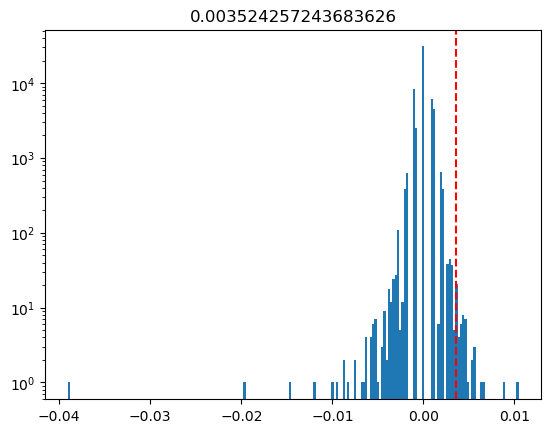

In [9]:
percentile_threshold = np.percentile(v,99.9)
plt.hist(v,bins=200);
plt.axvline(percentile_threshold,ls="--",c="r")
plt.title(percentile_threshold)
plt.yscale("log")

# when price falls twice in a row, 

In [179]:
%%time
def validate_df(loc, dfmpl_values):
    v0 = dfmpl_values[loc, 0] * dfmpl_values[loc, 4]
    v1 = dfmpl_values[loc + 1, 0] * dfmpl_values[loc + 1, 4]
    return v0 > v0_thres and v1 > v1_thres
threshold1 = -0.004
threshold2 = -0.004
v0_thres = 3e6
v1_thres = 3e6
ans = []
collated_data_list = []

for dfmpl, tickerpair, _ in dfmpl_list:
    df_v = dfmpl.values
    changes = (df_v[:, 3] - df_v[:, 0]) / df_v[:, 0]
    a4_1 = np.logical_and(changes[1:] < threshold1, changes[:-1] < threshold2)
    locs = np.where(a4_1)[0]
    if len(locs) > 0:
        chosen_locs = [loc for loc in locs if validate_df(loc, df_v)]
        if chosen_locs:
            collated_data = np.asarray([changes[loc:loc + 5] for loc in chosen_locs])
            collated_data_list.append(collated_data)

collated_data = np.vstack(collated_data_list)
mean_val = collated_data[:, 2].mean()
ans.append(mean_val)

CPU times: total: 31.2 ms
Wall time: 72.5 ms


# attempts to optimize the parameters

In [184]:
from scipy.optimize import minimize

def objective(params):
    threshold1, threshold2, v0_thres, v1_thres = params
    collated_data_list = []

    for dfmpl, _, _ in dfmpl_list:
        df_v = dfmpl.values
        changes = (df_v[:, 3] - df_v[:, 0]) / df_v[:, 0]
        a4_1 = np.logical_and(changes[1:] < threshold1, changes[:-1] < threshold2)
        locs = np.where(a4_1)[0]
        if locs.size > 0:
            chosen_locs = [loc for loc in locs if validate_df(loc, df_v)]
            if chosen_locs:
                collated_data = np.asarray([changes[loc:loc + 5] for loc in chosen_locs])
                collated_data_list.append(collated_data)
    print("1")
    collated_data = np.vstack(collated_data_list)
    mean_val = collated_data[:, 2].mean()
    return -mean_val # Since we want to maximize mean_val, we return its negative

def validate_df(loc, df_v):
    v0 = df_v[loc, 0] * df_v[loc, 4]
    v1 = df_v[loc + 1, 0] * df_v[loc + 1, 4]
    return v0 > v0_thres and v1 > v1_thres

In [185]:
%%time
# Set initial guesses and bounds for the parameters
initial_guess = [-0.004, -0.004, 3e6, 3e6]
bounds = [(-0.01, 0), (-0.01, 0), (1e6, 5e6), (1e6, 5e6)]

# Run the optimizer
result = minimize(objective, initial_guess, bounds=bounds)#, method='L-BFGS-B')

# Print the result
print('Optimized parameters:', result.x)
print('Maximized mean_val:', -result.fun)

1
1
1
1
1
Optimized parameters: [-4.e-03 -4.e-03  3.e+06  3.e+06]
Maximized mean_val: 0.0030963492110224556
CPU times: total: 250 ms
Wall time: 406 ms


In [4]:
%%time
import numpy as np
import pickle
with open("2_0_0_analysisdata/2_0_0dfmpl_list.pkl","rb")as f:
    dfmpl_list = pickle.load(f)
def objective(threshold1, threshold2, v0_thres, v1_thres):
    collated_data_list = []

    for dfmpl, _, _ in dfmpl_list:
        df_v = dfmpl.values
        changes = (df_v[:, 3] - df_v[:, 0]) / df_v[:, 0]
        a4_1 = np.logical_and(changes[1:] < threshold1, changes[:-1] < threshold2)
        locs = np.where(a4_1)[0]
        if locs.size > 0:
            chosen_locs = [loc for loc in locs if validate_df(loc, df_v, v0_thres, v1_thres)]
            if chosen_locs:
                collated_data = np.asarray([changes[loc:loc + 5] for loc in chosen_locs])
                collated_data_list.append(collated_data)

    collated_data = np.vstack(collated_data_list)
    mean_val = collated_data[:, 2].mean()
    return mean_val,collated_data[:, 2].size

def validate_df(loc, df_v, v0_thres, v1_thres):
    v0 = df_v[loc, 0] * df_v[loc, 4]
    v1 = df_v[loc + 1, 0] * df_v[loc + 1, 4]
    return v0 > v0_thres and v1 > v1_thres
size=4
threshold1_values = np.linspace(-0.01, 0, size)
threshold2_values = np.linspace(-0.01, 0, size)
v0_thres_values = np.linspace(1e6, 5e6, size)
v1_thres_values = np.linspace(1e6, 5e6, size)

best_parameters = None
best_mean_val = float('-inf')
ans_mean_array = []
ans_coun_array = []
for threshold1 in threshold1_values:
    for threshold2 in threshold2_values:
        for v0_thres in v0_thres_values:
            for v1_thres in v1_thres_values:
                mean_val,counts = objective(threshold1, threshold2, v0_thres, v1_thres)
                ans_mean_array.append(mean_val);ans_coun_array.append(counts)
                if mean_val > best_mean_val:
                    best_mean_val = mean_val
                    best_parameters = (threshold1, threshold2, v0_thres, v1_thres)

print('Best parameters:', best_parameters)
print('Best mean value:', best_mean_val)

Best parameters: (-0.01, -0.01, 5000000.0, 3666666.6666666665)
Best mean value: 0.013019511805619324
CPU times: total: 40.2 s
Wall time: 1min 3s


In [191]:
import numpy as np
from multiprocessing import Pool, cpu_count
with open("2_0_0_analysisdata/2_0_0dfmpl_list.pkl","rb")as f:
    dfmpl_list = pickle.load(f)
def objective(params):
    threshold1, threshold2, v0_thres, v1_thres = params
    collated_data_list = []

    for dfmpl, _, _ in dfmpl_list:
        df_v = dfmpl.values
        changes = (df_v[:, 3] - df_v[:, 0]) / df_v[:, 0]
        a4_1 = np.logical_and(changes[1:] < threshold1, changes[:-1] < threshold2)
        locs = np.where(a4_1)[0]
        if locs.size > 0:
            chosen_locs = [loc for loc in locs if validate_df(loc, df_v, v0_thres, v1_thres)]
            if chosen_locs:
                collated_data = np.asarray([changes[loc:loc + 5] for loc in chosen_locs])
                collated_data_list.append(collated_data)

    collated_data = np.vstack(collated_data_list)
    mean_val = collated_data[:, 2].mean()
    return mean_val, params

def validate_df(loc, df_v, v0_thres, v1_thres):
    v0 = df_v[loc, 0] * df_v[loc, 4]
    v1 = df_v[loc + 1, 0] * df_v[loc + 1, 4]
    return v0 > v0_thres and v1 > v1_thres
size=2
threshold1_values = np.linspace(-0.01, 0, size)
threshold2_values = np.linspace(-0.01, 0, size)
v0_thres_values = np.linspace(1e6, 5e6, size)
v1_thres_values = np.linspace(1e6, 5e6, size)

parameter_grid = [(threshold1, threshold2, v0_thres, v1_thres) 
                  for threshold1 in threshold1_values 
                  for threshold2 in threshold2_values 
                  for v0_thres in v0_thres_values 
                  for v1_thres in v1_thres_values]

In [1]:
import time

In [2]:
time.time()

1691168320.0828521

In [ ]:
            
%%time
# Create a pool of workers
pool = Pool(cpu_count())

# Evaluate the objective function in parallel over the parameter grid
results = pool.map(objective, parameter_grid)

# Find the best parameters
best_parameters = max(results, key=lambda x: x[0])[1]
best_mean_val = max(results, key=lambda x: x[0])[0]

print('Best parameters:', best_parameters)
print('Best mean value:', best_mean_val)

# reading results from optimisation

In [5]:
with open("2_0_0_analysisdata/2_0_0mpi_run_results.pkl","rb") as f:
    results = pickle.load(f)

In [8]:
results

256

In [13]:
max(results, key=lambda x: x[0]/x[2])

(0.010431226803769452, (-0.01, -0.01, 5000000.0, 5000000.0), 4)

Text(0.5, 1.0, 'avg = +0.31%($\\pm$0.78%)')

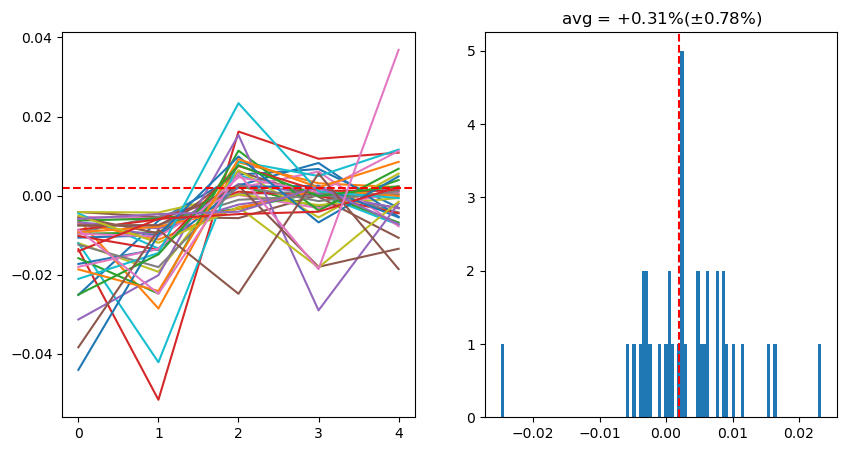

In [132]:
fig,axx=plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
ax.plot(collated_data.T)
ax.axhline(0.002,ls="--",c="r")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
ax.set_title(f"avg = {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})")

In [133]:
np.product(collated_data[:,2]+1-0.003)

1.0024526562869625

In [134]:
55000/60/24

38.19444444444444

In [18]:
listt_of_dfs = [1,2,3]

In [19]:
listt_of_dfs.pop(0)

1

In [20]:
listt_of_dfs

[2, 3]

In [21]:
listt_of_dfs.append(4)

In [22]:
listt_of_dfs

[2, 3, 4]

# trading implementation / algo

- subscribe to all data using websockets
- within each websocket instance, fetch data
- maintain a list of previous 2 candles
- once the current candle is determined to be changed, pop the list and append the new candle
    - then apply algorithm onto this list,
    - if criteria passed, send to master_trader.

In [1]:
import asyncio
from binance import AsyncClient, BinanceSocketManager
from binance.enums import *
import time
import datetime
from collections import Counter
import pickle
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)

In [ ]:
import subprocess


In [2]:
master_list=[[None] for _ in subset_symbols[:5]]
async def main(symbol='BNBBTC',idd=0):
    global master_list 
    await asyncio.sleep(idd*0.25)
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client) 
    ts = bm.kline_socket(symbol, interval=KLINE_INTERVAL_1MINUTE) 
    print(f"sub{idd}",end=" ")
    prev="0000";prev_df=[None]
    async with ts as tscm:
        while True:
            try:
                res = await tscm.recv() 
                if res["e"]=="error":
                    print(str(datetime.datetime.now())[11:-4],res)
                    raise Exception(res) 
                if prev != str(res["k"]["T"])[6:-3]: # a new change, so append the prev_df into the master_list
                    prev = str(res["k"]["T"])[6:-3]
                    ress=res["k"]
                    df = [ress["t"],float(ress["o"]),float(ress["c"]),float(ress["v"])] 
                    master_list[idd].append(prev_df.copy())
                    prev_df = df.copy()
                    if len(master_list[idd])>2:
                        master_list[idd].pop(0)
                        if master_list[idd][0] is not None:
                            # work on master_list since it has the latest dataset
                            dfloc0 = master_list[idd][0];dfloc1=master_list[idd][1]
                            v0 = dfloc0[1]*dfloc0[3];v1 = dfloc1[1]*dfloc1[3];
                            g0 = (dfloc0[2]-dfloc0[1])/dfloc0[1]
                            g1 = (dfloc1[2]-dfloc1[1])/dfloc1[1]
                            if v0>3e6 and v1>3e6 and g0<-0.008 and g1<-0.008:
                                #BUY signal!
                                cmd = ["python","aver6_master_trades.py",symbol,"15",str(datetime.datetime.now())[:-4],
                                       "TEST",f"{dfloc1[2]:.6g}","-0.008","-0.008","MOMENTUM","6969"]
                                cmd = " ".join(cmd)
                                subprocess.Popen( cmd , shell=True)
            except Exception as e:
                print(symbol,e,str(e))
                break
    await client.close_connection()
    print(f"ended {symbol}")

In [4]:
%%time
loop = asyncio.get_event_loop()
#loop.run_until_complete(main())
for idd,s in enumerate(subset_symbols[:5]):
    asyncio.run_coroutine_threadsafe(main(s+"USDT",idd), loop)
    #time.sleep(0.4)

CPU times: total: 0 ns
Wall time: 997 µs
sub0 sub1 sub2 sub3 sub4 some error at BTCUSDT
ended BTCUSDT
some error at XRPUSDT
some error at SOLUSDT
ended XRPUSDT
ended SOLUSDT
some error at XLMUSDT
ended XLMUSDT
some error at ETHUSDT
ended ETHUSDT


In [3]:
res={'e': 'kline',
 'E': 1690906998648,
 's': 'BNBBTC',
 'k': {'t': 1690906980000,
  'T': 1690907039999,
  's': 'BNBBTC',
  'i': '1m',
  'f': 225658046,
  'L': 225658048,
  'o': '0.00845600',
  'c': '0.00845600',
  'h': '0.00845600',
  'l': '0.00845600',
  'v': '0.27500000',
  'n': 3,
  'x': False,
  'q': '0.00232539',
  'V': '0.27500000',
  'Q': '0.00232539',
  'B': '0'}}
res

{'e': 'kline',
 'E': 1690906998648,
 's': 'BNBBTC',
 'k': {'t': 1690906980000,
  'T': 1690907039999,
  's': 'BNBBTC',
  'i': '1m',
  'f': 225658046,
  'L': 225658048,
  'o': '0.00845600',
  'c': '0.00845600',
  'h': '0.00845600',
  'l': '0.00845600',
  'v': '0.27500000',
  'n': 3,
  'x': False,
  'q': '0.00232539',
  'V': '0.27500000',
  'Q': '0.00232539',
  'B': '0'}}

In [4]:
ress=res["k"]
ress["t"],float(ress["o"]),float(ress["c"]),float(ress["v"])

(1690906980000, 0.008456, 0.008456, 0.275)

In [8]:
hehe=[23,4,1,5]

In [9]:
hehe2=hehe.copy()

In [10]:
hehe2[3]=123
hehe,hehe2

([23, 4, 1, 5], [23, 4, 1, 123])

In [27]:
import traceback
try:
    assert False
except Exception as e:
    #traceback.print_stack()#(e.__traceback__)
    strr=traceback.format_exc()
    print("hehe",strr)
    

hehe Traceback (most recent call last):
  File "C:\Users\aatan\AppData\Local\Temp\ipykernel_12056\263919594.py", line 3, in <module>
    assert False
AssertionError



In [28]:
strr

'Traceback (most recent call last):\n  File "C:\\Users\\aatan\\AppData\\Local\\Temp\\ipykernel_12056\\263919594.py", line 3, in <module>\n    assert False\nAssertionError\n'